# Lab2
Coding assignment 2 is released [here](https://github.com/sqrta/CMSC457-Spring23). Check the link on Piazza. This GitHub repo will also be used for releasing future coding assignments.

Coding assignment 1 due today (11pm).

## What we're going to cover
- Deutsch-Josza algorithm
- Solving Sudoku using Grover's Algorithm

---
## Deutsch's Algorithm

We have a black box circuit to apply to one bit $x$, that performs the mapping
$$|x,y\rangle \mapsto |x,y \oplus f(x)\rangle,$$
where $f(x)$ is also a single bit.

We want to learn whether $f(x)$ is _constant_ or _balanced_. A constant function takes $0$ for all inputs or it takes $1$ for all inputs. A balanced function takes $0$ on half of the inputs and $1$ on the other half.

### Classical Solution

Classically, in the best case, two queries to the oracle can determine if the hidden Boolean function, $f(x)$, is balanced: e.g. if we get both $f(x_1)=0$ and $f(x_2)=1$ for some $x_1,x_2$, then we know the function is balanced as we have obtained the two different outputs.

In the worst case, if we continue to see the same output for each input we try, we will have to check exactly half of all possible inputs plus one in order to be certain that $f(x)$ is constant (i.e. $O(N/2)$).

### Quantum Solution

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $|x,y\rangle \mapsto |x,y \oplus f(x)\rangle$
![](deutsch_steps.png)

In [101]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram


Let's start by creating a constant oracle, in this case the input has no effect on the output so we just randomly set the output qubit to be 0 or 1:

In [103]:
# set the length of the n-bit input string. 
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘

We can also create a balance oracle

In [104]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()

┌───┐ ░                 ░ ┌───┐
q_0: ┤ X ├─░───■─────────────░─┤ X ├
     └───┘ ░   │             ░ └───┘
q_1: ──────░───┼────■────────░──────
     ┌───┐ ░   │    │        ░ ┌───┐
q_2: ┤ X ├─░───┼────┼────■───░─┤ X ├
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░──────
           ░ └───┘└───┘└───┘ ░

Let's now put everything together. This first step in the algorithm is to initialize the input qubits in the state $\ket{+}$ and the output qubit in the state $\ket{-}$

In [105]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()

┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘
c: 3/══════════

Next, let's apply the oracle. Here we apply the constant oracle.

In [109]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit=dj_circuit.compose(const_oracle) 
dj_circuit.draw()

┌───┐          
q_0: ┤ H ├──────────
     ├───┤          
q_1: ┤ H ├──────────
     ├───┤          
q_2: ┤ H ├──────────
     ├───┤┌───┐┌───┐
q_3: ┤ X ├┤ H ├┤ X ├
     └───┘└───┘└───┘
c: 3/═══════════════

Finally, we perform H-gates on the $n$-input qubits, and measure our input register:

In [110]:

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

┌───┐┌───┐      ░ ┌─┐      
q_0: ┤ H ├┤ H ├──────░─┤M├──────
     ├───┤├───┤      ░ └╥┘┌─┐   
q_1: ┤ H ├┤ H ├──────░──╫─┤M├───
     ├───┤├───┤      ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├──────░──╫──╫─┤M├
     ├───┤├───┤┌───┐ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤ X ├─░──╫──╫──╫─
     └───┘└───┘└───┘ ░  ║  ║  ║ 
c: 3/═══════════════════╩══╩══╩═
                        0  1  2

Let's see the output:

In [111]:
# use local simulator
simulator = Aer.get_backend('aer_simulator')
result = simulator.run(dj_circuit,shots=10000).result()
counts = result.get_counts(dj_circuit)
print(counts)

{'000': 10000}


# Grover's algorithm Review

Grover's algorithm is arguably one of the canonical quantum algorithms that kick-started the field of quantum computing. In the future, it could possibly serve as a hallmark application of quantum computing. Grover's algorithm allows us to find a particular register in an unordered database with $N$ entries in just $O(\sqrt{N})$ steps, compared to the best classical algorithm taking on average $N/2$ steps, thereby providing a __quadratic speedup__.

Research has been shown that any optimal quantum solution to an unstructured search problem has a speed limit of $O(\sqrt{N})$ runtime. This research finding matches the performance of Grover's algorithm, thus proving that the algorithm is asymptotically optimal [2]. In fact, Grover's algorithm can be generalized to accelerate any type of search where one can construct a quantum oracle, as described in the next section. 

Consider the following problem [2]: 
In a search space with $N$ elements, we are searching the index of those elements, which is a number in the range $0, 1, \dots, N-1$. 
We have $n$ bits at our disposal, with which we can store up to $2^{n}$ elements. 
Our search problem can then be expressed with the help of a function $f$, which takes as input an element out of our set of indices (that is, an integer $x$) and generates two possible outputs: $f(x^{*})=1$, if $x^{*}$ is the solution to the search problem or $f(x)=0$ otherwise (if $N<2^{n}$ we can just set $f(x)=0$ for all extra unused elements). 
This is done with the help of a quantum oracle, which recognizes solutions to the search problem. 

# Anatomy of Grover's Algorithm <a name="steps"></a>

1. **Initialize**: Start with a uniform superposition of all possible bit strings by applying Hadamard gates. This will result in all inputs having the same amplitude. Since we do not have any prior knowledge about the solution, we initialize to an equal superposition of all possible candidate solutions. 

2. **Oracle**: Item bits are then passed through an oracle. The oracle produces only two results. If it detects the target item, its amplitude will be flipped to negative. For all other items, their amplitudes will remain positive. Because the oracle is specifically engineered to change amplitudes based on a certain bit pattern, each target item would have its own associated oracle.

To create an Grover search oracle, recall that we need our circuit $U_w$ to perform the transformation:
$$
U_w |x\rangle  \mapsto \begin{cases}
|x\rangle , x\neq w\\
-|x\rangle, x=w\\
\end{cases}
$$

3. **Amplification**: While the oracle in step 2 distinguishes the target item by flipping its amplitude in the negative direction, this difference remains too small to detect. Hence, we use a trick to magnify the difference in amplitudes; by flipping every amplitude around the mean amplitude. Recall that only the target item's amplitude was flipped to negative. In other words, the mean amplitude would still be positive, and its value would only be slightly lower than the amplitudes of other items. By flipping all amplitudes about the mean, the amplitudes of non-target items would decrease only slightly. On the other hand, the amplitude of the target item, being much less than the mean value to start, would be reflected back up into the positive direction by a large margin.

4. **Repeat**: By repeating steps 2 and 3, we can magnify the amplitude of the target item to a point where it can be identified with overwhelming probability. To get to this point, we need to repeat these steps approximately $\sqrt{N}$ times (again assuming a single solution and large $N$). As discussed in more detail in our Quantum Amplification Algorithm (QAA) tutorial, to ensure we measure a solution with high probability, we apply the Grover iterator $\left\lfloor\frac{\pi}{4\theta}\right\rfloor=\left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{G}}\right\rfloor$ times, with $G$ denoting the number of solutions. Since we may not know $G$ in advance, we not know the ideal number of iterations a priori. To address this issue, however, we may use quantum counting techniques with the help of the phase estimation procedure (QPE); for details we refer to Ref.[2]. 

5. **Measurement**: Measure the resulting amplitudes to identify the target item.
6. ![image.png](grover.jpg)

## Solving Sudoku using Grover's Algorithm

The oracles used throughout this chapter so far have been created with prior knowledge of their solutions. We will now solve a simple problem using Grover's algorithm, for which we do not necessarily know the solution beforehand. Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

- No column may contain the same value twice
- No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

![](binary_sudoku.png)

we want our circuit to output a solution to this sudoku.

Note that, while this approach of using Grover's algorithm to solve this problem is not practical (you can probably find the solution in your head!), the purpose of this example is to demonstrate the conversion of classical decision problems into oracles for Grover's algorithm.

### Turning the Problem into a Circuit

We want to create an oracle that will help us solve this problem, and we will start by creating a circuit that identifies a correct solution. Similar to how we created a classical adder using quantum circuits in The Atoms of Computation, we simply need to create a classical function on a quantum circuit that checks whether the state of our variable bits is a valid solution.

Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

- v0 ≠ v1   # check along top row
- v2 ≠ v3   # check along bottom row
- v0 ≠ v2   # check down left column
- v1 ≠ v3   # check down right column

Remember we are comparing classical (computational basis) states. For convenience, we can compile this set of comparisons into a list of clauses:

In [88]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

This circuit `XOR` checks whether `a` == `b` and stores the output to `output`. To check each clause, we repeat this circuit for each pairing in clause_list and store the output to a new bit:

In [112]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

v_0: ──■─────────■───────────────────────────
       │         │                           
v_1: ──┼────■────┼─────────■─────────────────
       │    │    │         │                 
v_2: ──┼────┼────┼────■────┼─────────■───────
       │    │    │    │    │         │       
v_3: ──┼────┼────┼────┼────┼────■────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼──
                         └───┘└───┘┌─┴─┐┌─┴─┐
c_3: ──────────────────────────────┤ X ├┤ X ├
                                   └───┘└───┘

The final state of the bits c0, c1, c2, c3 will only all be 1 in the case that the assignments of v0, v1, v2, v3 are a solution to the sudoku. To complete our checking circuit, we want a single bit to be 1 if (and only if) all the clauses are satisfied, this way we can look at just one bit to see if our assignment is a solution. We can do this using a multi-controlled-Toffoli-gate:

In [113]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()


v_0: ──■─────────■────────────────────────────────
       │         │                                
v_1: ──┼────■────┼─────────■──────────────────────
       │    │    │         │                      
v_2: ──┼────┼────┼────■────┼─────────■────────────
       │    │    │    │    │         │            
v_3: ──┼────┼────┼────┼────┼────■────┼────■───────
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                         └───┘└───┘┌─┴─┐┌─┴─┐  │  
c_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                   └───┘└───┘┌─┴─┐
out: ────────────────────────────────────────┤ X ├
                                             └───┘

The circuit above takes as input an initial assignment of the bits v0, v1, v2 and v3, and all other bits should be initialized to 0. After running the circuit, the state of the out0 bit tells us if this assignment is a solution or not; out0 = 0 means the assignment is not a solution, and out0 = 1 means the assignment is a solution.

### Uncomputing, and Completing the Oracle

We can now turn this checking circuit into a Grover oracle using phase kickback. To recap, we have 3 registers:

- One register which stores our sudoku variables ($v_0,v_1,v_2,v_3$)
- One register that stores our clauses ($c_0,c_1,c_2,c_3$. This one starts in the state $|0000\rangle$)
- And one qubit $|out\rangle$ that we've been using to store the output of our checking circuit.

To create an Grover search oracle, recall that we need our circuit $U_w$ to perform the transformation:
$$
U_w |x\rangle  \mapsto \begin{cases}
|x\rangle , x\neq w\\
-|x\rangle, x=w\\
\end{cases}
$$
The circuit we defined above will flip the qubit `out` when $x=w$. So if we set qubit `out` to the state $|-\rangle$, since
$$
X|-\rangle = X \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)=\frac{1}{\sqrt{2}}(|1\rangle-|0\rangle) = -|-\rangle
$$
So our circuit should be the transformation
$$
V_w |x\rangle |0\rangle |-\rangle \mapsto \begin{cases}
|x\rangle |0\rangle |-\rangle, x\neq w\\
-|x\rangle |0\rangle |-\rangle, x=w\\
\end{cases}
$$

In [114]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

qc.x(output_qubit)
qc.h(output_qubit)
sudoku_oracle(qc, clause_list, clause_qubits)
qc.h(output_qubit)
qc.x(output_qubit)
qc.draw()

»
    v_0: ──■─────────■──────────────────────────────────■─────────■────────────»
           │         │                                  │         │            »
    v_1: ──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──»
           │    │    │         │                        │    │    │         │  »
    v_2: ──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼──»
           │    │    │    │    │         │              │    │    │    │    │  »
    v_3: ──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼──»
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │  »
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼──»
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼──»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐»
    c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├»
                             └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘»
    c_3: ──────────────────────────────┤ X ├┤ X ├──■───────────────────────────»
         ┌───┐┌───┐                    └───┘└───┘┌─┴─┐┌───┐┌───┐               »
    out: ┤ X ├┤ H ├──────────────────────────────┤ X ├┤ H ├┤ X ├───────────────»
         └───┘└───┘                              └───┘└───┘└───┘               »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                        
«    v_0: ───────────────
«                        
«    v_1: ───────────────
«                        
«    v_2: ───────■───────
«                │       
«    v_3: ──■────┼────■──
«           │    │    │  
«    c_0: ──┼────┼────┼──
«           │    │    │  
«    c_1: ──┼────┼────┼──
«         ┌─┴─┐  │    │  
«    c_2: ┤ X ├──┼────┼──
«         └───┘┌─┴─┐┌─┴─┐
«    c_3: ─────┤ X ├┤ X ├
«              └───┘└───┘
«    out: ───────────────
«                        
«cbits: 4/═══════════════
«

Then we need to build the diffuser operation.

In [115]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

The full algorithm

In [126]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

Iteration = 2
for i in range(Iteration):
    # Apply our oracle
    sudoku_oracle(qc, clause_list, clause_qubits)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(4), [0,1,2,3])


# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

┌───┐               ░                                                                                       ░ ┌────────┐                                                                                      ░ ┌────────┐┌─┐         
    v_0: ─────────────┤ H ├───────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├──■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├┤M├─────────
                      ├───┤               ░   │         │                                  │         │                            ░ │        │  │         │                                  │         │                            ░ │        │└╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├─╫─┤M├──────
                      ├───┤               ░   │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │  │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │ ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├─╫──╫─┤M├───
                      ├───┤               ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │  │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │ ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├─╫──╫──╫─┤M├
                      └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘ ║  ║  ║ └╥┘
    c_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░───────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░            ║  ║  ║  ║ 
    c_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░─────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░            ║  ║  ║  ║ 
    c_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░───────────────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░────────────╫──╫──╫──╫─
                                          ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░                               └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░            ║  ║  ║  ║ 
    c_3: ─────────────────────────────────░───────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░─────────────────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├

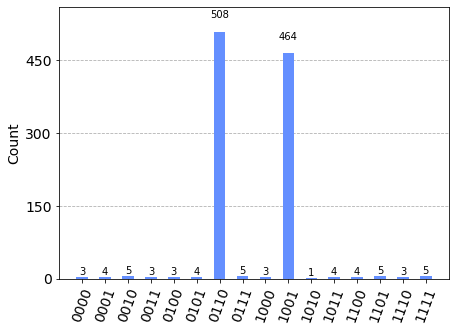

In [127]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())